### Business Case

Apple and Google are looking to analyze what people are saying about their brand in twitter. People use twitter to share their impulsive yet honest thoughts and opinions. This can provide brands a good idea on what consumers are really feeling about their products. 

In order to achieve this, we will take the following steps:

EDA:
* Explore the contents of the tweet to identify the product and sentiment of the tweet.
* Analyze the sentiments to identify common issues or contentment expressed by the user.
* Make some meaningful recommendations to the brands that they can use to serve their customers better.

Modeling:
* Build a model that can classify the tweets into positive, negative or neutral emotions.
* Deploy the model for production to track customer sentiments in real-time.

In [1]:
# Import relevant packages

import pandas as pd
import numpy as np
from numpy import random

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
import statistics

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import keras
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.layers import Embedding
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.collocations import *
import nltk
nltk.download('averaged_perceptron_tagger')

from wordcloud import WordCloud

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dicch\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Dataset

In [2]:
# Import the dataset

df_raw = pd.read_csv(r'tweet_product_company.csv', encoding= 'unicode_escape')

In [3]:
df_raw.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df_raw.shape

(9093, 3)

### Data Understanding

In [5]:
# Check for missing values

df_raw.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

* More than half of the values are missing in the second columns. We will create our to code to identify the product. Let's drop this column for now. 
* We will also drop the 1 missing row from our dataset.

In [6]:
df_raw.drop('emotion_in_tweet_is_directed_at', axis=1, inplace=True)

In [7]:
df_raw.dropna(axis=0, inplace=True)

In [8]:
df_raw.isnull().sum()

tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

Let's also rename the target column for ease of use.

In [9]:
df_raw.rename({'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, axis=1, inplace=True)

In [10]:
df_raw.head()

,tweet_text,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


#### Target Variable

In [11]:
df_raw.emotion.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

We can see that there are more unknown emotions than Positive and Negative emotions. This means that there is huge class imbalances present in the data.

Furthermore:
- The 'No emotion toward brand or product' class can be renamed to 'Neutral emotion'. 
- 'I can't tell' can be dropped as it only has 156 items.

In [12]:
# Rename neutral emotion

df_raw.emotion = df_raw.emotion.map(lambda x: 'Neutral emotion' if x == 'No emotion toward brand or product' else x)

In [13]:
df_raw.emotion.value_counts()

Neutral emotion     5388
Positive emotion    2978
Negative emotion     570
I can't tell         156
Name: emotion, dtype: int64

In [14]:
# Slice out the fourth class

df_clean = df_raw[df_raw.emotion != "I can't tell"].copy()

In [15]:
df_clean.emotion.value_counts()

Neutral emotion     5388
Positive emotion    2978
Negative emotion     570
Name: emotion, dtype: int64

We now only have three final classes.

#### Input Variable

Let's observe some of the tweets individually to see what kind of characters or sentence structure we are working with here.

In [16]:
# Review sample tweets

list(df_clean.tweet_text[:10])

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd',
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaV

Looking at the first 10 tweets, we can see that:
 
* The tweets usually have one or more twitter handles.
* Hashtags are used before relevant keywords and the tweets also have multiple special characters.
* The sentiments are expressed pretty clearly for each brand, which will make it easy for us to classify the data.

But first we need to reduce each tweet to contain only words for EDA and modeling.

### Data Preparation

### Tokenize the data

Using nltk and some code, we can easily tokenize the tweets to its simplest form.

In [17]:
# Download stopwords from nltk

nltk.download('stopwords')

# Create a list of stopwords and add punctuation to remove them both
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

tokenized_tweet = []
# Loop in to access individual tweets
for i in df_clean.index:
    tweet = df_clean.tweet_text[i]
        
    # tokenize each tweet
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tweet_tokens_raw = nltk.regexp_tokenize(tweet, pattern)
        
    # lowercase each token
    tweet_tokens = [word.lower() for word in tweet_tokens_raw]
        
    # remove stopwords and punctuations
    tweet_words_stopped = [word for word in tweet_tokens if word not in stopwords_list] 
    
    # append the tokens into tokenized_tweets
    tokenized_tweet.append(tweet_words_stopped)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dicch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# Add the tokenized tweets back into our dataframe

df_clean['tokenized_tweet'] = tokenized_tweet

In [19]:
df_clean.head()

,tweet_text,emotion,tokenized_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,"[wesley, g, iphone, hrs, tweeting, rise, austi..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon..."
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,"[sxsw, hope, year's, festival, crashy, year's,..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


We can now use the tokenized tweets to identify the brand or product mentioned in each tweet.

### Identify Brand Mentions

In [20]:
# Create list of words/products that identify the brand

apple = ['ipad', 'iphone', 'imac', 'iwatch', 'itunes', 'icloud', 'apple', 'mac', 'macbook', 'macpro']
google = ['google']

We will create a dictionary to populate 'Apple' and 'Google' each time the tweet mentions one of it's products. 

We will also use the index as keys in our dictionary so that we can match it with the tweet index later and categorize it accordingly.

In [21]:
product = {}
for i in df_clean.index:
    for word in df_clean.tokenized_tweet[i]:
        if word in apple:
            product[i] = word
            break
        elif word in google:
            product[i] = 'google'
            break

Let's transform this into a dataframe so that we can join back with our tweet dataframe.

In [22]:
df_product = pd.DataFrame.from_dict(product, orient='index')
df_product.rename(columns={0:'product'}, inplace=True)

In [23]:
df_product.head()

,product
0,iphone
1,ipad
2,ipad
3,iphone
4,google


Since we have matching indexes we can join the two dataframes using index as key.

In [24]:
df_clean = df_clean.join(df_product, how='inner')

In [25]:
df_clean.head()

,tweet_text,emotion,tokenized_tweet,product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,"[wesley, g, iphone, hrs, tweeting, rise, austi...",iphone
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon...",ipad
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]",ipad
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,"[sxsw, hope, year's, festival, crashy, year's,...",iphone
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",google


In [26]:
df_clean.shape

(7647, 4)

We now have our own column that identifies which brand or product the tweet is directed towards.

### EDA 1 -  Analyze the Emotion and Brand mentions

Now that we have the products and emotion of the tweet, let's plot the contents to visualize our findings.

In [27]:
# Count product mentions and save it in a dataframe

product_count = pd.DataFrame(df_clean['product'].value_counts()).copy()
product_count

,product
google,2238
ipad,2118
apple,1742
iphone,1442
itunes,70
mac,23
macbook,13
imac,1


#### All Product Mentions

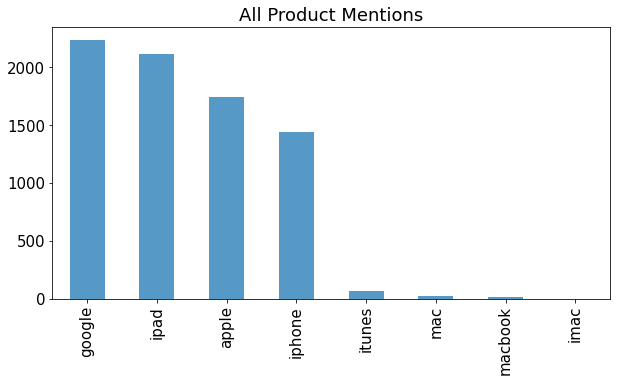

In [28]:
# plot a histogram

product_count.plot(kind='bar', figsize=(10,5), fontsize=15, alpha=.75, legend=False)

plt.title('All Product Mentions', fontsize=18)
plt.savefig(r'Images/All_Product_Mentions.jpg', bbox_inches='tight');

#### Apple Product Mentions

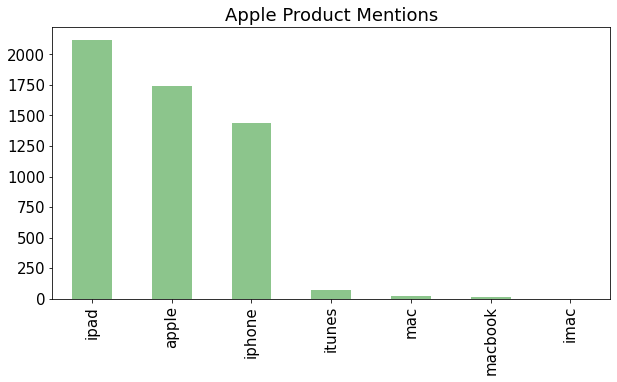

In [29]:
# Plot apple products

product_count[1:].plot(kind='bar', figsize=(10,5), fontsize=15, color='green', alpha=.45, legend=False)

plt.title('Apple Product Mentions', fontsize=18)
plt.savefig(r'Images/Apple_Mentions.jpg', bbox_inches='tight');

Ipad seems to have been the topic for conversation in the SXSW event. Followed by Apple and Iphone.

#### Apple vs Google

In [30]:
# Count the number of Apple mentions

apple_total = product_count['product'][1:].sum()
apple_total

5409

In [31]:
# Count the number of Google mentions

google_total = product_count['product'][0]
google_total

2238

In [32]:
# Put the count in a dataframe

apple_google = pd.DataFrame([5409,2238], ['Apple', 'Google']).rename({0:'Brand'}, axis=1)
apple_google

,Brand
Apple,5409
Google,2238


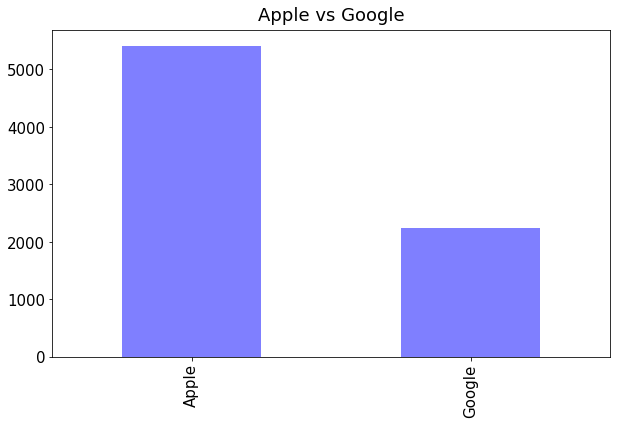

In [33]:
# Plot the histogram

apple_google.plot(kind='bar', figsize=(10,6), fontsize=15, color='blue', alpha=0.5, legend=False)

plt.title('Apple vs Google', fontsize=18, pad=10)
plt.savefig(r'Images/Brand_Mentions.jpg', bbox_inches='tight');

In terms of brand, Apple seems to be getting more customer engagement.

#### Total Sentiment Expressed

In [34]:
# Put the sentiment count in a dataframe

sentiments_total = pd.DataFrame(df_clean['emotion'].value_counts()).copy()
sentiments_total

,emotion
Neutral emotion,4367
Positive emotion,2738
Negative emotion,542


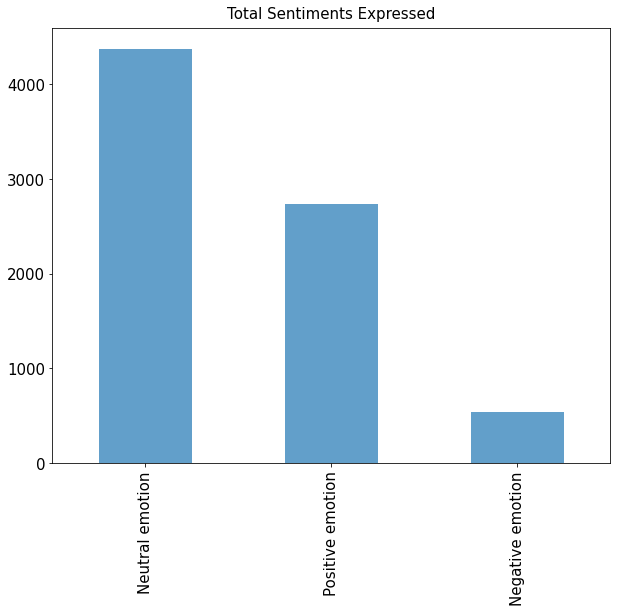

In [35]:
# Plot the histogram

sentiments_total.plot(kind='bar', figsize=(10,8), fontsize=15, alpha=0.7, legend=False)

plt.title('Total Sentiments Expressed', fontsize=15, pad=10);
plt.savefig(r'Images/Total_Sentiment_Expressed.jpg', bbox_inches='tight')

Although most sentiments are neutral, there seems to be a positive outlook for all products.

#### Sentiments by Brand

In [36]:
# Create a dataframe with count of each emotion for every product 

df_emotion = pd.DataFrame(df_clean[['product','emotion']].value_counts().copy())
df_emotion.head()

,,0
product,emotion,
google,Neutral emotion,1478
ipad,Neutral emotion,1053
apple,Neutral emotion,974
ipad,Positive emotion,900
iphone,Neutral emotion,791


In [37]:
# Sort the Product to group all emotions together

df_emotion.sort_values(by='product', inplace=True)

In [38]:
df_emotion.head()

0
product emotion               
apple   Negative emotion    97
        Neutral emotion    974
        Positive emotion   671
google  Neutral emotion   1478
        Positive emotion   627

In [39]:
# Transpose the dataframe to pull count by column names

cross_table = df_emotion.transpose()
cross_table

product            apple                                           google  \
emotion Negative emotion Neutral emotion Positive emotion Neutral emotion   
0                     97             974              671            1478   

product                                               imac             ipad  \
emotion Positive emotion Negative emotion Negative emotion Positive emotion   
0                    627              133                1              900   

product                                   ...           iphone  \
emotion Negative emotion Neutral emotion  ... Negative emotion   
0                    165            1053  ...              143   

product                          itunes                                    \
emotion Neutral emotion Neutral emotion Positive emotion Negative emotion   
0                   791              54               15                1   

product             mac                                            macbook  \
emotion Neutral emotion Positive emotion Negative emotion Positive emotion   
0                    11               10                2                7   

product                  
emotion Neutral emotion  
0                     6  

[1 rows x 21 columns]

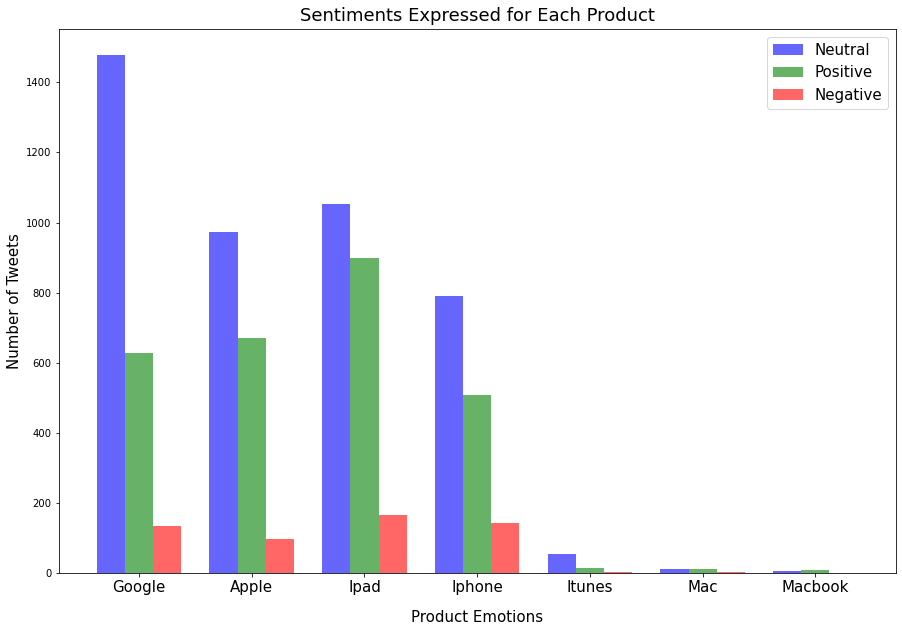

In [40]:
# Plot the histogram

fig, ax = plt.subplots(figsize=(15,10))

alpha = 0.6
width = .25
x = 0.75

ax.bar(x, cross_table['google']['Neutral emotion'], width, color='b', alpha=alpha)
ax.bar(x + width, cross_table['google']['Positive emotion'], width, color='g',alpha=alpha)
ax.bar(x + (width * 2), cross_table['google']['Negative emotion'], width, color='r',alpha=alpha)

ax.bar(x+1, cross_table['apple']['Neutral emotion'], width, color='b',alpha=alpha)
ax.bar(x+1 + width, cross_table['apple']['Positive emotion'], width, color='g',alpha=alpha)
ax.bar(x+1 + (width * 2), cross_table['apple']['Negative emotion'], width, color='r',alpha=alpha)

ax.bar(x+2, cross_table['ipad']['Neutral emotion'], width, color='b',alpha=alpha)
ax.bar(x+2 + width, cross_table['ipad']['Positive emotion'], width, color='g',alpha=alpha)
ax.bar(x+2 + (width * 2), cross_table['ipad']['Negative emotion'], width, color='r',alpha=alpha)

ax.bar(x+3, cross_table['iphone']['Neutral emotion'], width, color='b',alpha=alpha)
ax.bar(x+3 + width, cross_table['iphone']['Positive emotion'], width, color='g',alpha=alpha)
ax.bar(x+3 + (width * 2), cross_table['iphone']['Negative emotion'], width, color='r',alpha=alpha)

ax.bar(x+4, cross_table['itunes']['Neutral emotion'], width, color='b',alpha=alpha)
ax.bar(x+4 + width, cross_table['itunes']['Positive emotion'], width, color='g',alpha=alpha)
ax.bar(x+4 + (width * 2), cross_table['itunes']['Negative emotion'], width, color='r',alpha=alpha)

ax.bar(x+5, cross_table['mac']['Neutral emotion'], width, color='b',alpha=alpha)
ax.bar(x+5 + width, cross_table['mac']['Positive emotion'], width, color='g',alpha=alpha)
ax.bar(x+5 + (width * 2), cross_table['mac']['Negative emotion'], width, color='r',alpha=alpha)

ax.bar(x+6, cross_table['macbook']['Neutral emotion'], width, color='b',alpha=alpha)
ax.bar(x+6 + width, cross_table['macbook']['Positive emotion'], width, color='g',alpha=alpha)
ax.bar(x+6 + (width * 2), 0, width, color='r',alpha=alpha)

ax.set_title('Sentiments Expressed for Each Product', fontsize=18, pad=8)
ax.set_xlabel('Product Emotions', labelpad=15, fontsize=15)
ax.set_ylabel('Number of Tweets', fontsize=15)

ax.set_xticks(range(1,8))
ax.set_xticklabels(('Google', 'Apple', 'Ipad', 'Iphone', 'Itunes', 'Mac', 'Macbook'), fontsize=15)

ax.legend(('Neutral', 'Positive', 'Negative'), fontsize=15)

plt.savefig(r'Images/Sentiment_Distribution.jpg', bbox_inches='tight')
plt.show();

The plots gives us a good indication on the overall consensus of the customer sentiments across all products.

Let's check the exact words or emotion expressed by the customers.

### EDA 2 - Analyze the tweets to identify common issues or contentment expressed by the user

For this part of our EDA, we will generate POS tags to distinguish the words and grab the one's that best expresses the issue.

### POS Tags

In [41]:
# Loop through the toknenized tweets to create the POS tags

pos_tags = []

for i in range(len(df_clean)):
    pos_tags.append(nltk.pos_tag(df_clean.tokenized_tweet.iloc[i]))

In [42]:
# Add the pos_tags into the dataframe

df_clean['pos_tags'] = pos_tags

In [43]:
# Sample some of the pos tags to check where most of the emotions or relevant words are stored

list(df_clean.pos_tags.iloc[:10])

[[('wesley', 'NN'),
  ('g', 'NN'),
  ('iphone', 'NN'),
  ('hrs', 'NN'),
  ('tweeting', 'VBG'),
  ('rise', 'NN'),
  ('austin', 'NN'),
  ('dead', 'JJ'),
  ('need', 'NN'),
  ('upgrade', 'JJ'),
  ('plugin', 'NN'),
  ('stations', 'NNS'),
  ('sxsw', 'VBP')],
 [('jessedee', 'NN'),
  ('know', 'VBP'),
  ('fludapp', 'VBZ'),
  ('awesome', 'JJ'),
  ('ipad', 'NN'),
  ('iphone', 'NN'),
  ('app', 'NN'),
  ('likely', 'JJ'),
  ('appreciate', 'NN'),
  ('design', 'NN'),
  ('also', 'RB'),
  ("they're", 'VBZ'),
  ('giving', 'VBG'),
  ('free', 'JJ'),
  ('ts', 'NN'),
  ('sxsw', 'NN')],
 [('swonderlin', 'NN'),
  ('wait', 'NN'),
  ('ipad', 'NN'),
  ('also', 'RB'),
  ('sale', 'NN'),
  ('sxsw', 'NN')],
 [('sxsw', 'NNS'),
  ('hope', 'VBP'),
  ("year's", 'JJ'),
  ('festival', 'NN'),
  ('crashy', 'NN'),
  ("year's", 'NN'),
  ('iphone', 'NN'),
  ('app', 'NN'),
  ('sxsw', 'NN')],
 [('sxtxstate', 'NN'),
  ('great', 'JJ'),
  ('stuff', 'NN'),
  ('fri', 'NN'),
  ('sxsw', 'NN'),
  ('marissa', 'FW'),
  ('mayer', 'NN'),
  (

Looking at the above list, we can see that most of the emotions are expresses in JJ tag which stands for adjectives used in the tweet.

Let's create a column to store all adjectives expressed in the tweet.

In [44]:
# Loop through the words and grab all adjectives

expression = []

for tweet in df_clean.pos_tags:
    emotion = []
    
    for item in tweet:  
        if item[1] == 'JJ':
            emotion.append(item[0])
        else:
            pass
    expression.append(emotion)

In [45]:
# Add the adjective list to the dataframe

df_clean['expression'] = expression

In [46]:
df_clean.head()

,tweet_text,emotion,tokenized_tweet,product,pos_tags,expression
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,"[wesley, g, iphone, hrs, tweeting, rise, austi...",iphone,"[(wesley, NN), (g, NN), (iphone, NN), (hrs, NN...","[dead, upgrade]"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon...",ipad,"[(jessedee, NN), (know, VBP), (fludapp, VBZ), ...","[awesome, likely, free]"
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]",ipad,"[(swonderlin, NN), (wait, NN), (ipad, NN), (al...",[]
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,"[sxsw, hope, year's, festival, crashy, year's,...",iphone,"[(sxsw, NNS), (hope, VBP), (year's, JJ), (fest...",[year's]
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",google,"[(sxtxstate, NN), (great, JJ), (stuff, NN), (f...","[great, tech, matt]"


Now that we have a view on what the users are saying about each brand. Let's look into each product and identify the most common expressions used.

In order to do this, we will split the dataframe by products and analyze the sentiments individually.

In [47]:
# Identify all products

df_clean['product'].value_counts()

google     2238
ipad       2118
apple      1742
iphone     1442
itunes       70
mac          23
macbook      13
imac          1
Name: product, dtype: int64

There is only one instance of imac. Let's combine this with mac but name it as imac.

In [48]:
df_clean['product'].replace({'mac':'imac'}, inplace=True)

In [49]:
df_clean['product'].value_counts()

google     2238
ipad       2118
apple      1742
iphone     1442
itunes       70
imac         24
macbook      13
Name: product, dtype: int64

In [50]:
# Create a dictonary to store dataframes by product

products = list(set(df_clean['product']))

product_dict = {}
for product in products:
    product_dict[f'{product}_df'] = df_clean[df_clean['product'] == product].copy()

In [51]:
product_dict.keys()

dict_keys(['imac_df', 'google_df', 'itunes_df', 'iphone_df', 'macbook_df', 'ipad_df', 'apple_df'])

### Most Common Expressions

Let's create a function to grab the most common expressions.

In [52]:
def most_common(df, n, m):
    
    # parameters:
    # df = dataframe
    # n = number of common words you want to grab
    # m = number of common words to skip
    
    
    # Slice the dataframe into positive, negative and neutral emotions
    positive = df[df['emotion'] == 'Positive emotion'].copy()
    negative = df[df['emotion'] == 'Negative emotion'].copy()
    neutral = df[df['emotion'] == 'Neutral emotion'].copy()
    
    # Positive emotions
    
    # Compile all expressions into a bag of words
    positive_corpus = []
    for word in positive['expression']:
        positive_corpus += word
        
    # Create a list of words with their frequency distribution
    positive_freqdist = FreqDist(positive_corpus)
    positive_most_common = positive_freqdist.most_common(n)[m:]
    
    
    # Negative emotions
    
    # Compile all expressions into a bag of words
    negative_corpus = []
    for word in negative['expression']:
        negative_corpus += word
        
    # Create a list to store the frequency distribution
    negative_freqdist = FreqDist(negative_corpus)
    negative_most_common = negative_freqdist.most_common(n)[m:]
    
    
    # Neutral emotions
    
    # Compile all expressions into a bag of words
    neutral_corpus = []
    for word in neutral['expression']:
        neutral_corpus += word
        
    # Create a list of words with their frequency distribution
    neutral_freqdist = FreqDist(neutral_corpus)
    neutral_most_common = neutral_freqdist.most_common(n)[m:]
    
    # Complile the results into a dictionary
    results = {}
    results['positive_most_common'] = positive_most_common
    results['negative_most_common'] = negative_most_common
    results['neutral_most_common'] = neutral_most_common
    
    return results

Let's look into what customers are saying about each product.

In [53]:
product_dict.keys()

dict_keys(['imac_df', 'google_df', 'itunes_df', 'iphone_df', 'macbook_df', 'ipad_df', 'apple_df'])

#### Apple

In [54]:
most_common(product_dict['apple_df'], 15, 3)

{'positive_most_common': [('open', 56),
  ('ipad', 45),
  ('cool', 45),
  ('new', 33),
  ('great', 29),
  ('smart', 24),
  ('nice', 15),
  ('austin', 15),
  ('quot', 14),
  ('temp', 14),
  ('good', 13),
  ('brilliant', 13)],
 'negative_most_common': [('elegant', 7),
  ('ipad', 5),
  ('temporary', 4),
  ('good', 4),
  ('quot', 4),
  ('microsoft', 3),
  ('bad', 2),
  ('pop', 2),
  ('mobile', 2),
  ('smugness', 2),
  ('update', 2),
  ('enchantment', 2)],
 'neutral_most_common': [('open', 110),
  ('ipad', 51),
  ('new', 42),
  ('austin', 32),
  ('temp', 19),
  ('quot', 18),
  ('amp', 14),
  ('popup', 13),
  ('many', 13),
  ('pop', 12),
  ('downtown', 12),
  ('launch', 11)]}

Apple is mainly quoted as 'cool', 'new', 'great', 'smart' and 'nice'. However, there are some cases of it being expressed as 'bad' and being smug 'smugness'.

#### Google

In [55]:
most_common(product_dict['google_df'], 15, 5)

{'positive_most_common': [('major', 54),
  ('quot', 53),
  ('google', 49),
  ('great', 48),
  ('good', 26),
  ('big', 23),
  ('free', 19),
  ('digital', 16),
  ('physical', 15),
  ('launch', 13)],
 'negative_most_common': [('major', 12),
  ('quot', 7),
  ('much', 7),
  ('technical', 5),
  ('false', 4),
  ('great', 4),
  ('launch', 3),
  ('many', 3),
  ('good', 3),
  ('open', 3)],
 'neutral_most_common': [('google', 148),
  ('quot', 115),
  ('mobile', 103),
  ('big', 58),
  ('launch', 44),
  ('amp', 36),
  ('digital', 33),
  ('physical', 29),
  ('connect', 21),
  ('future', 20)]}

Google is expressed as 'major', 'great', 'good', 'big' and 'digital' in positive connotations. 'False' is the only negative word that we can make any sense of in the negative words. 

#### Macbook

In [56]:
most_common(product_dict['macbook_df'], 15, 3)

{'positive_most_common': [('macbook', 1),
  ('solo', 1),
  ('snap', 1),
  ('tiny', 1),
  ('temporary', 1),
  ('right', 1)],
 'negative_most_common': [],
 'neutral_most_common': [('non', 1),
  ('instagram', 1),
  ('hyatt', 1),
  ('practical', 1),
  ('rt', 1),
  ('macbook', 1),
  ('pro', 1)]}

For positive comments, customers has expressed Macbook as 'tiny' and 'right'. There are no negative cases here as well.

#### Ipad

In [57]:
most_common(product_dict['ipad_df'], 15, 3)

{'positive_most_common': [('new', 89),
  ('great', 40),
  ('free', 29),
  ('good', 27),
  ('awesome', 24),
  ('app', 22),
  ('quot', 18),
  ('last', 17),
  ('first', 17),
  ('laptop', 16),
  ('white', 15),
  ('nice', 14)],
 'negative_most_common': [('new', 16),
  ('quot', 9),
  ('digital', 8),
  ('tapworthy', 8),
  ('many', 4),
  ('first', 4),
  ('ridiculous', 4),
  ('laptop', 3),
  ('w', 3),
  ('weird', 3),
  ('live', 3),
  ('next', 3)],
 'neutral_most_common': [('new', 100),
  ('free', 48),
  ('quot', 40),
  ('able', 24),
  ('social', 23),
  ('last', 20),
  ('laptop', 18),
  ('temporary', 18),
  ('amp', 17),
  ('white', 16),
  ('first', 16),
  ('u', 15)]}

Ipad is expressed as 'new', 'great', 'good', 'awesome', and 'nice' for positives. While it is quoted as 'ridiculous' and 'weird' for those who were not too impressed by it.

#### Imac

In [58]:
most_common(product_dict['imac_df'], 15, 2)

{'positive_most_common': [('sweet', 1),
  ('temporary', 1),
  ('rare', 1),
  ('obsolete', 1),
  ('rt', 1),
  ('glad', 1),
  ('cool', 1),
  ('tweetie', 1),
  ('amp', 1),
  ('wish', 1),
  ('android', 1),
  ('temp', 1),
  ('ipad', 1)],
 'negative_most_common': [],
 'neutral_most_common': [('special', 2),
  ('ipad', 2),
  ('happened', 2),
  ('obsolete', 2),
  ('rt', 2),
  ('mac', 2),
  ('full', 1),
  ('app', 1),
  ('long', 1),
  ('laptop', 1)]}

Imac's are commented as 'cool' and 'rare' in positive expressions. There are no negative comments here as well.

#### Itunes

In [59]:
most_common(product_dict['itunes_df'], 15, 3)

{'positive_most_common': [('listen', 1),
  ('amp', 1),
  ('android', 1),
  ('unimitated', 1),
  ('scan', 1),
  ('ipad', 1),
  ('great', 1),
  ('sxsw', 1),
  ('rt', 1),
  ('good', 1),
  ('freemusic', 1)],
 'negative_most_common': [],
 'neutral_most_common': [('featured', 4),
  ('download', 4),
  ('guide', 2),
  ('available', 2),
  ('quot', 2),
  ('live', 2),
  ('album', 2),
  ('mix', 2),
  ('cc', 2),
  ('various', 2),
  ('mexican', 1),
  ('listen', 1)]}

You can see above that customers have expressed Itunes as 'unimitated', 'great', 'good' and 'free music' for positive scenarios. There is no negative adjectives present for Itunes in our dataset. Neutral comments does not really matter in our analysis. 

#### Iphone

In [60]:
most_common(product_dict['iphone_df'], 15, 4)

{'positive_most_common': [('free', 45),
  ('awesome', 28),
  ('ubersocial', 21),
  ('uberguide', 21),
  ('app', 19),
  ('android', 16),
  ('next', 16),
  ('cool', 15),
  ('hot', 14),
  ('good', 14),
  ('ready', 13)],
 'negative_most_common': [('new', 6),
  ('good', 6),
  ('many', 5),
  ('quot', 5),
  ('u', 5),
  ('mobile', 4),
  ('dead', 3),
  ('stupid', 3),
  ('great', 3),
  ('ubersocial', 3),
  ('uberguide', 3)],
 'neutral_most_common': [('free', 52),
  ('mobile', 44),
  ('ubersocial', 44),
  ('uberguide', 44),
  ('android', 40),
  ('mashable', 25),
  ('quot', 20),
  ('last', 19),
  ('next', 19),
  ('good', 13),
  ('amp', 12)]}

Lastly, Iphones are quoted as 'awesome', 'cool', 'hot' and 'good' when in favor. It is also quoted as 'dead' and 'stupid' in some negative tweets. 

Let's plot these in a wordcloud to visualize the most common words.

### Apple Words

In [61]:
# Create a list of positive and negative words

apple_positives = ('Great ' * 7 + 'Cool ' * 6 + 'Awesome ' * 5 + 'Nice ' * 3 + 'Hot ' * 2 + 'Brilliant ' * 1) 
apple_negatives = ('Ridiculous ' * 4 +  'Weird ' * 3 + 'Dead ' * 3 + 'Stupid ' * 3 + 'Smug ' * 2)

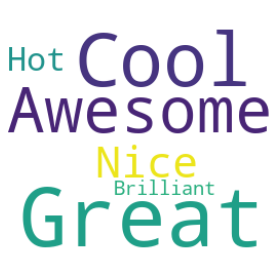

In [62]:
# Create the wordcloud object

wordcloud = WordCloud(width=400, height=400, margin=0,
                     background_color='white', scale=0.65,
                     relative_scaling=.75, repeat=False,
                     min_font_size=10).generate(apple_positives)
    
# Display the generated image

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
wordcloud.to_file(r'Images/apple_postive_wordcloud.jpg');

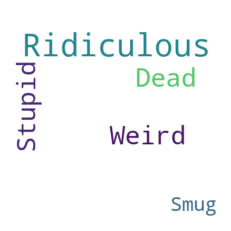

In [63]:
# Create the wordcloud object

wordcloud = WordCloud(width=640, height=640, margin=0,
                     background_color='white', scale=0.65,
                     relative_scaling=.75, repeat=False,
                     min_font_size=10).generate(apple_negatives)
    
# Display the generated image

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
wordcloud.to_file(r'Images/apple_negative_wordcloud.jpg');

### Google Words

In [64]:
# Create a list of postivive and negative words

google_positives = ('Major ' * 6 + 'Great ' * 5 + 'Big ' * 2)
google_negatives = ('False ' * 4)

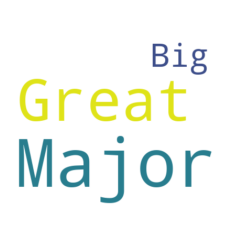

In [65]:
# Create the wordcloud object

wordcloud = WordCloud(width=640, height=640, margin=0,
                     background_color='white', scale=0.65,
                     relative_scaling=.75, repeat=False,
                     min_font_size=10).generate(google_positives)
    
# Display the generated image

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
wordcloud.to_file(r'Images/google_positive_wordcloud.jpg');

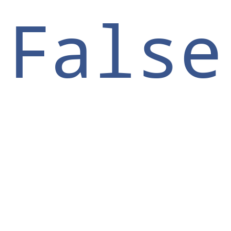

In [66]:
# Create the wordcloud object

wordcloud = WordCloud(width=640, height=640, margin=0,
                     background_color='white', scale=0.65,
                     relative_scaling=.75, repeat=False,
                     min_font_size=10).generate(google_negatives)
    
# Display the generated image

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
wordcloud.to_file(r'Images/google_negative_wordcloud.jpg');

Now that we know what customers are saying about each brand and product, we can move onto the machine learning part of this project where we will create a classifier to predict positive, negative and neutral tweets.

### Data Preparation

In [67]:
# Create a copy of the dataframe for safe modeling

df_final = df_clean.copy()

First, we need to transform the target variables into numerical classes.

In [70]:
df_final.emotion = df_final.emotion.map({'Neutral emotion':0,
                                         'Positive emotion':1,
                                         'Negative emotion':2})

In [71]:
# Preview the dataset

df_clean.head()

,tweet_text,emotion,tokenized_tweet,product,pos_tags,expression
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,"[wesley, g, iphone, hrs, tweeting, rise, austi...",iphone,"[(wesley, NN), (g, NN), (iphone, NN), (hrs, NN...","[dead, upgrade]"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon...",ipad,"[(jessedee, NN), (know, VBP), (fludapp, VBZ), ...","[awesome, likely, free]"
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]",ipad,"[(swonderlin, NN), (wait, NN), (ipad, NN), (al...",[]
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,"[sxsw, hope, year's, festival, crashy, year's,...",iphone,"[(sxsw, NNS), (hope, VBP), (year's, JJ), (fest...",[year's]
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",google,"[(sxtxstate, NN), (great, JJ), (stuff, NN), (f...","[great, tech, matt]"


We will use the TD-IDF vectorizer to transform our text into a numerical format. This way the computer can understand the characterstics of the text and classify it appropriately.

We will need to use the raw tweet_text column for the TD-IDF vectorizer as it handles the count vectorization process on it's own.

Before we do that, let's split our dataset into train and test datasets.

### Train test split

In [72]:
# Declare independent and target variable

X = df_final['tweet_text'].copy()
y = df_final['emotion'].copy()

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

### TF-IDF Vectorizer

In [74]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform train and test sets
tf_idf_train = vectorizer.fit_transform(X_train)
tf_idf_test = vectorizer.transform(X_test)

In [75]:
tf_idf_train.shape

(5352, 7480)

The vectorized product shows that we have 5352 tweets in our train set with 7480 unique words.

Now that we have our dataset vectorized, we can fit them in different models and start predicting. 

Let's create a function to test different models.

In [76]:
def pred_score(classifier):
    
    # Instantiate and fit the model
    clf = classifier
    clf.fit(tf_idf_train, y_train)
    
    # Predict the training and test sets
    train_preds = clf.predict(tf_idf_train)
    test_preds = clf.predict(tf_idf_test)
    
    # Calculate and print accuracy scores
    print(clf)
    print('----------------------------------')
    train_score = accuracy_score(y_train, train_preds) *100
    print('Training accuracy: {}'.format(train_score)) 
    test_score = accuracy_score(y_test, test_preds) *100
    print('Test accuracy: {}'.format(test_score))

### Naive Bayes

In [77]:
pred_score(MultinomialNB())

MultinomialNB()
----------------------------------
Training accuracy: 73.93497757847534
Test accuracy: 63.13725490196078


The NB model seems to have performed averagely at 63.14% test accuracy. The training accuracy is higher than the test accuracy which shows signs of overfitting.

### Random Forest Classifier

In [78]:
pred_score(RandomForestClassifier(n_estimators=100))

RandomForestClassifier()
----------------------------------
Training accuracy: 99.64499252615845
Test accuracy: 66.1437908496732


The RandomForestClassifier seems to have performed a bit better than the NB model at 66.14% test accuracy. The model was able to train itself on the training dataset pretty well however, it was not able to generalize well on the test set.

Text classification is not as straight forward as label classification. Recurring Neural Networks using the LSTM architecture usually perform very well with text classification. We will deploy the neural network to classify our data.

### Recurring Neural Network using LTSM

RNN works better in dense vectors rather than sparse vectors. We will need to perform Word Embedding separately using Keras to run our model.

#### Word Embedding

First, we need to transform our array of text to 2D numerical arrays

In [79]:
max_words = 5000
max_len = 40

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_words)

# Fit the text
tokenizer.fit_on_texts(X)

# Convert list of strings to list list of interegers
sequences = tokenizer.texts_to_sequences(X)

# Pad the tweets to a max of 40 features
tweets = pad_sequences(sequences, maxlen=max_len)

print(tweets)

[[   0    0    0 ... 3490    6    1]
 [   0    0    0 ... 3491    6    1]
 [   0    0    0 ...  192    6    1]
 ...
 [   0    0    0 ...    4    9   33]
 [   0    0    0 ...  140 3305    1]
 [   0    0    0 ...    6    1    4]]


In [80]:
# Create train and test sets for these transformed arrays

X2_train, X2_test, y2_train, y2_test = train_test_split(tweets, y, test_size=.30, random_state=111)

In [81]:
# Declare the independent variable

X2 = df_clean['tweet_text'].copy()

Since this is a multiclass problem, we need to encode our target variables.

In [83]:
# Use Keras to encode labels into 3 classes

y2_train = keras.utils.to_categorical(y2_train, 3)
y2_test = keras.utils.to_categorical(y2_test, 3)

#### Base model - LSTM

In [87]:
# Build the model
model = Sequential()

# Add the embedding layer
model.add(layers.Embedding(max_words, 40))

# Add the LSTM layer with dropout
model.add(layers.LSTM(20, dropout=0.3)) 

# Final layer using softmax
model.add(layers.Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
# Inspect the shape of your model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 40)          200000    
_________________________________________________________________
lstm (LSTM)                  (None, 20)                4880      
_________________________________________________________________
dense (Dense)                (None, 3)                 63        
Total params: 204,943
Trainable params: 204,943
Non-trainable params: 0
_________________________________________________________________


We can see in the above table that we have 3 layers and 204,943 traininable parameters. 

In [89]:
# Fit the model
result_1 = model.fit(X2_train, y2_train, epochs=20, validation_data=(X2_test, y2_test))

Epoch 1/20
168/168 [==============================] - 4s 22ms/step - loss: 0.8665 - accuracy: 0.5710 - val_loss: 0.8555 - val_accuracy: 0.5752
Epoch 2/20
168/168 [==============================] - 3s 17ms/step - loss: 0.7911 - accuracy: 0.6256 - val_loss: 0.8445 - val_accuracy: 0.6078
Epoch 3/20
168/168 [==============================] - 3s 18ms/step - loss: 0.7114 - accuracy: 0.6863 - val_loss: 0.8400 - val_accuracy: 0.5699
Epoch 4/20
168/168 [==============================] - 3s 17ms/step - loss: 0.6461 - accuracy: 0.7207 - val_loss: 0.7939 - val_accuracy: 0.6505
Epoch 5/20
168/168 [==============================] - 3s 17ms/step - loss: 0.6006 - accuracy: 0.7479 - val_loss: 0.7615 - val_accuracy: 0.6566
Epoch 6/20
168/168 [==============================] - 3s 17ms/step - loss: 0.5531 - accuracy: 0.7754 - val_loss: 0.7852 - val_accuracy: 0.6632
Epoch 7/20
168/168 [==============================] - 3s 15ms/step - loss: 0.5234 - accuracy: 0.7881 - val_loss: 0.8136 - val_accuracy: 0.6357

In [90]:
# Evaluate the model
loss, accuracy = model.evaluate(X2_test, y2_test)
print('Test Accuracy: %f' % (accuracy*100))

72/72 [==============================] - 0s 4ms/step - loss: 0.9612 - accuracy: 0.6314
Test Accuracy: 63.137257


The unsupervised model with 20 epochs does not seem to have predicted the model any better than the supervised ones. The test accuracy is still 63.14%. Let's visualize this to get a better understanding of our model's performance.

### Visualizing Loss and Accuracy Curves

In [91]:
# Create a function to plot loss and accuracy curves

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

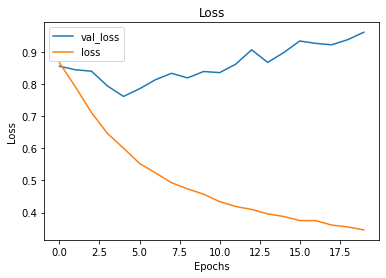

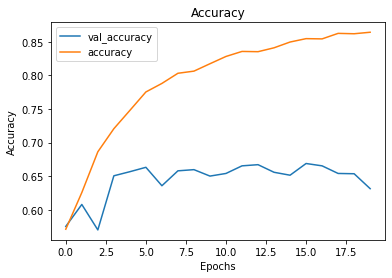

In [92]:
visualize_training_results(result_1)

Our validation accuracy is way lower than the training accuracy. This shows that our model is overfitting. One way for tackling overfitting is by regularization using dropout layers in the model. Let's see if we can improve the model performance with this.

#### Model 2 - Dropout

In [93]:
model2 = Sequential()
# Add the embedding layer
model2.add(layers.Embedding(max_words, 40))

# Add the LSTM layer with dropout
model2.add(layers.LSTM(20, dropout=0.3)) 

# Add second layer using relu activation
model2.add(layers.Dense(15, activation='relu'))
# Implement dropout to the second hidden layer 
model2.add(layers.Dropout(0.3))

# Add third dense layer using relu activation
model2.add(layers.Dense(10, activation='relu'))
# Implement dropout to the third hidden layer 
model2.add(layers.Dropout(0.3))

# Final layer using softmax
model2.add(layers.Dense(3, activation='softmax'))

# Compile the model
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

# Inspect the model
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 40)          200000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                4880      
_________________________________________________________________
dense_1 (Dense)              (None, 15)                315       
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

We now have an extra layers in our model with dropout. Let's see how this performs.

We can also use EarlyStopping from keras.callbacks to stop the model from running through all epochs when it starts to overfit.

In [94]:
# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [95]:
# Fit the model
result_2 = model2.fit(X2_train, y2_train, epochs=50, callbacks=early_stopping, validation_data=(X2_test, y2_test))

Epoch 1/50
168/168 [==============================] - 4s 21ms/step - loss: 0.9418 - accuracy: 0.5682 - val_loss: 0.8852 - val_accuracy: 0.5699
Epoch 2/50
168/168 [==============================] - 3s 20ms/step - loss: 0.8582 - accuracy: 0.5787 - val_loss: 0.8363 - val_accuracy: 0.5935
Epoch 3/50
168/168 [==============================] - 3s 20ms/step - loss: 0.8216 - accuracy: 0.6314 - val_loss: 0.8390 - val_accuracy: 0.6009
Epoch 4/50
168/168 [==============================] - 3s 19ms/step - loss: 0.7766 - accuracy: 0.6741 - val_loss: 0.8878 - val_accuracy: 0.6166
Epoch 5/50
168/168 [==============================] - 3s 19ms/step - loss: 0.7552 - accuracy: 0.6947 - val_loss: 0.8358 - val_accuracy: 0.6318
Epoch 6/50
168/168 [==============================] - 3s 19ms/step - loss: 0.7267 - accuracy: 0.7059 - val_loss: 0.8323 - val_accuracy: 0.6309
Epoch 7/50
168/168 [==============================] - 3s 19ms/step - loss: 0.6988 - accuracy: 0.7294 - val_loss: 0.8395 - val_accuracy: 0.5939

In [96]:
# Load the best (saved) model
saved_model = load_model('best_model.h5')

In [97]:
# Evaluate the model
loss, accuracy = saved_model.evaluate(X2_test, y2_test)
print('Test Accuracy: %f' % (accuracy*100))

72/72 [==============================] - 0s 4ms/step - loss: 0.8323 - accuracy: 0.6309
Test Accuracy: 63.093680


The dropout model does not seem to have improved.

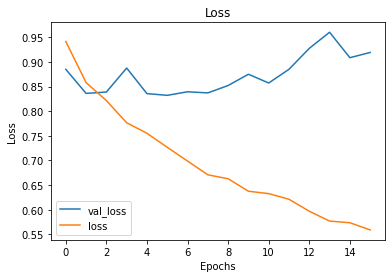

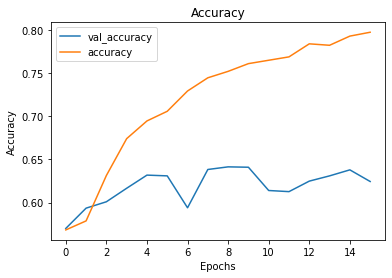

In [98]:
visualize_training_results(result_2)

The model did not improve. Let's try other activation functions.

#### Model 3 - Activation: sigmoid

In [99]:
model3 = Sequential()
# Add the embedding layer
model3.add(layers.Embedding(max_words, 40))

# Add the LSTM layer with dropout
model3.add(layers.LSTM(30, dropout=0.3)) 

# Add second layer using relu activation
model3.add(layers.Dense(20, activation='relu'))
# Implement dropout to the second hidden layer 
model3.add(layers.Dropout(0.3))

# Add third dense layer using relu activation
model3.add(layers.Dense(10, activation='relu'))
# Implement dropout to the third hidden layer 
model3.add(layers.Dropout(0.3))

# Final layer using softmax
model3.add(layers.Dense(3, activation='sigmoid'))

# Compile the model
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

# Inspect the model
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 40)          200000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                8520      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                

In [100]:
# Define the callbacks
early_stopping_3 = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model3.h5', monitor='val_loss', save_best_only=True)]

In [101]:
# Fit the model
result_3 = model3.fit(X2_train, y2_train, epochs=50, callbacks=early_stopping_3, validation_data=(X2_test, y2_test))

Epoch 1/50
168/168 [==============================] - 4s 22ms/step - loss: 0.9303 - accuracy: 0.5486 - val_loss: 0.8790 - val_accuracy: 0.5699
Epoch 2/50
168/168 [==============================] - 3s 20ms/step - loss: 0.8894 - accuracy: 0.5604 - val_loss: 0.8558 - val_accuracy: 0.5699
Epoch 3/50
168/168 [==============================] - 3s 20ms/step - loss: 0.8578 - accuracy: 0.5626 - val_loss: 0.8442 - val_accuracy: 0.5699
Epoch 4/50
168/168 [==============================] - 3s 20ms/step - loss: 0.8348 - accuracy: 0.5686 - val_loss: 0.8417 - val_accuracy: 0.5699
Epoch 5/50
168/168 [==============================] - 3s 20ms/step - loss: 0.8219 - accuracy: 0.5684 - val_loss: 0.8390 - val_accuracy: 0.5699
Epoch 6/50
168/168 [==============================] - 3s 20ms/step - loss: 0.8096 - accuracy: 0.5676 - val_loss: 0.8449 - val_accuracy: 0.5699
Epoch 7/50
168/168 [==============================] - 3s 20ms/step - loss: 0.7942 - accuracy: 0.5760 - val_loss: 0.8381 - val_accuracy: 0.5725

In [102]:
# Load the best (saved) model
saved_model_3 = load_model('best_model3.h5')

# Evaluate the model
loss, accuracy = saved_model_3.evaluate(X2_test, y2_test)
print('Test Accuracy: %f' % (accuracy*100))

72/72 [==============================] - 0s 5ms/step - loss: 0.8347 - accuracy: 0.6048
Test Accuracy: 60.479301


The sigmoid fuction seems to have performed even more poorely.

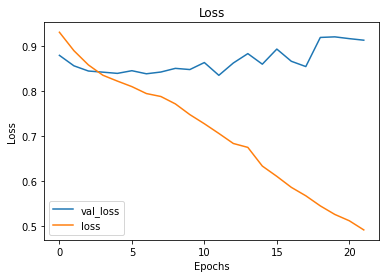

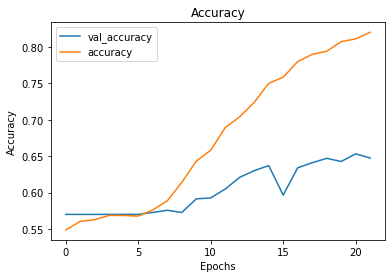

In [103]:
visualize_training_results(result_3)

#### Model 4: Adam optimizaiton

In [104]:
model4 = Sequential()
# Add the embedding layer
model4.add(layers.Embedding(max_words, 40))

# Add the LSTM layer with dropout
model4.add(layers.LSTM(20, dropout=0.3)) 

# Add second layer using relu activation
model4.add(layers.Dense(15, activation='relu'))
# Implement dropout to the second hidden layer 
model4.add(layers.Dropout(0.3))

# Add third dense layer using relu activation
model4.add(layers.Dense(10, activation='relu'))
# Implement dropout to the third hidden layer 
model4.add(layers.Dropout(0.3))

# Add third dense layer using relu activation
model4.add(layers.Dense(5, activation='relu'))
# Implement dropout to the third hidden layer 
model4.add(layers.Dropout(0.3))

# Final layer using softmax
model4.add(layers.Dense(3, activation='softmax'))

# Compile the model
model4.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Inspect the model
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 40)          200000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 20)                4880      
_________________________________________________________________
dense_7 (Dense)              (None, 15)                315       
_________________________________________________________________
dropout_4 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                160       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                

In [105]:
# Define the callbacks
early_stopping_4 = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model4.h5', monitor='val_loss', save_best_only=True)]

In [106]:
# Fit the model
result_4 = model4.fit(X2_train, y2_train, epochs=50, callbacks=early_stopping_4, validation_data=(X2_test, y2_test))

Epoch 1/50
168/168 [==============================] - 4s 22ms/step - loss: 0.9647 - accuracy: 0.5277 - val_loss: 0.8782 - val_accuracy: 0.5699
Epoch 2/50
168/168 [==============================] - 3s 19ms/step - loss: 0.8835 - accuracy: 0.5510 - val_loss: 0.8374 - val_accuracy: 0.5699
Epoch 3/50
168/168 [==============================] - 3s 19ms/step - loss: 0.8292 - accuracy: 0.5716 - val_loss: 0.8434 - val_accuracy: 0.5699
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.7786 - accuracy: 0.5893 - val_loss: 0.8564 - val_accuracy: 0.6065
Epoch 5/50
168/168 [==============================] - 3s 18ms/step - loss: 0.7226 - accuracy: 0.6609 - val_loss: 0.9187 - val_accuracy: 0.6092
Epoch 6/50
168/168 [==============================] - 3s 17ms/step - loss: 0.6817 - accuracy: 0.6997 - val_loss: 0.9075 - val_accuracy: 0.5922
Epoch 7/50
168/168 [==============================] - 3s 18ms/step - loss: 0.6416 - accuracy: 0.7319 - val_loss: 0.9634 - val_accuracy: 0.5843

In [107]:
# Load the best (saved) model
saved_model_4 = load_model('best_model4.h5')

# Evaluate the model
loss, accuracy = saved_model_4.evaluate(X2_test, y2_test)
print('Test Accuracy: %f' % (accuracy*100))

72/72 [==============================] - 0s 4ms/step - loss: 0.8374 - accuracy: 0.5699
Test Accuracy: 56.993467


The adam optimizer seems to have performed even more worse.

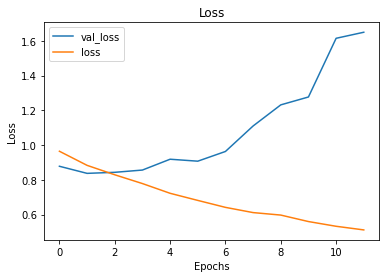

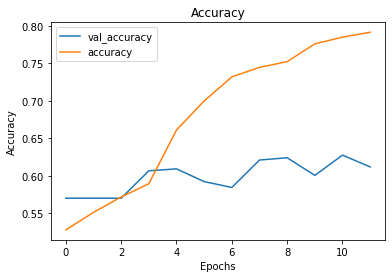

In [108]:
visualize_training_results(result_4)

#### Model 5: L2 Regularization

In [109]:
model5 = Sequential()
# Add the embedding layer
model5.add(layers.Embedding(max_words, 40))

# Add the LSTM layer with dropout
model5.add(layers.LSTM(20, dropout=0.3)) 

# Add second layer using relu activation with l2 regularization
model5.add(layers.Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Final layer using softmax
model5.add(layers.Dense(3, activation='softmax'))

# Compile the model
model5.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

# Inspect the model
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 40)          200000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                4880      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 33        
Total params: 205,123
Trainable params: 205,123
Non-trainable params: 0
_________________________________________________________________


In [110]:
# Define the callbacks
early_stopping_5 = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model5.h5', monitor='val_loss', save_best_only=True)]

# Fit the model
result_5 = model5.fit(X2_train, y2_train, epochs=50, callbacks=early_stopping_5, validation_data=(X2_test, y2_test))

Epoch 1/50
168/168 [==============================] - 4s 22ms/step - loss: 0.9753 - accuracy: 0.5559 - val_loss: 0.9144 - val_accuracy: 0.5699
Epoch 2/50
168/168 [==============================] - 3s 18ms/step - loss: 0.8654 - accuracy: 0.5899 - val_loss: 0.8776 - val_accuracy: 0.5865
Epoch 3/50
168/168 [==============================] - 3s 19ms/step - loss: 0.7928 - accuracy: 0.6652 - val_loss: 0.8253 - val_accuracy: 0.6353
Epoch 4/50
168/168 [==============================] - 3s 18ms/step - loss: 0.7364 - accuracy: 0.7037 - val_loss: 0.8130 - val_accuracy: 0.6344
Epoch 5/50
168/168 [==============================] - 3s 19ms/step - loss: 0.6959 - accuracy: 0.7233 - val_loss: 0.8091 - val_accuracy: 0.6488
Epoch 6/50
168/168 [==============================] - 3s 18ms/step - loss: 0.6585 - accuracy: 0.7470 - val_loss: 0.7994 - val_accuracy: 0.6471
Epoch 7/50
168/168 [==============================] - 3s 18ms/step - loss: 0.6234 - accuracy: 0.7586 - val_loss: 0.8349 - val_accuracy: 0.6505

In [111]:
# Load the best (saved) model
saved_model_5 = load_model('best_model5.h5')

# Evaluate the model
loss, accuracy = saved_model_5.evaluate(X2_test, y2_test)
print('Test Accuracy: %f' % (accuracy*100))

72/72 [==============================] - 0s 4ms/step - loss: 0.7994 - accuracy: 0.6471
Test Accuracy: 64.705884


We still do not see any improvement in the model.

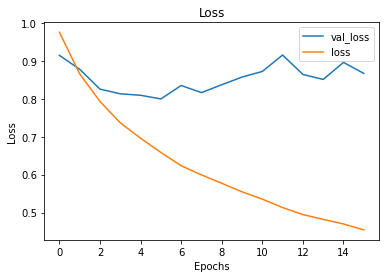

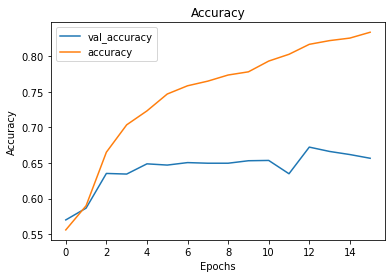

In [112]:
visualize_training_results(result_5)

#### Model 6: L1 Regularization

In [113]:
model6 = Sequential()
# Add the embedding layer
model6.add(layers.Embedding(max_words, 40))

# Add the LSTM layer with dropout
model6.add(layers.LSTM(20, dropout=0.3)) 

# Add second layer using relu activation with l2 regularization
model6.add(layers.Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))

# Final layer using sigmoid
model6.add(layers.Dense(3, activation='sigmoid'))

# Compile the model
model6.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

# Inspect the model
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 40)          200000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                4880      
_________________________________________________________________
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 33        
Total params: 205,123
Trainable params: 205,123
Non-trainable params: 0
_________________________________________________________________


In [114]:
# Define the callbacks
early_stopping_6 = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model6.h5', monitor='val_loss', save_best_only=True)]

# Fit the model
result_6 = model6.fit(X2_train, y2_train, epochs=50, callbacks=early_stopping_6, validation_data=(X2_test, y2_test))

Epoch 1/50
168/168 [==============================] - 4s 22ms/step - loss: 1.0526 - accuracy: 0.5689 - val_loss: 1.0112 - val_accuracy: 0.5699
Epoch 2/50
168/168 [==============================] - 3s 18ms/step - loss: 0.9313 - accuracy: 0.5788 - val_loss: 0.9357 - val_accuracy: 0.5765
Epoch 3/50
168/168 [==============================] - 3s 19ms/step - loss: 0.8412 - accuracy: 0.6394 - val_loss: 0.9317 - val_accuracy: 0.5930
Epoch 4/50
168/168 [==============================] - 3s 19ms/step - loss: 0.7733 - accuracy: 0.6895 - val_loss: 0.8471 - val_accuracy: 0.6248
Epoch 5/50
168/168 [==============================] - 3s 19ms/step - loss: 0.7168 - accuracy: 0.7214 - val_loss: 0.8422 - val_accuracy: 0.6366
Epoch 6/50
168/168 [==============================] - 3s 19ms/step - loss: 0.6768 - accuracy: 0.7410 - val_loss: 0.8570 - val_accuracy: 0.6357
Epoch 7/50
168/168 [==============================] - 3s 19ms/step - loss: 0.6411 - accuracy: 0.7573 - val_loss: 0.8401 - val_accuracy: 0.6505

In [115]:
# Load the best (saved) model
saved_model_6 = load_model('best_model6.h5')

# Evaluate the model
loss, accuracy = saved_model_6.evaluate(X2_test, y2_test)
print('Test Accuracy: %f' % (accuracy*100))

72/72 [==============================] - 0s 4ms/step - loss: 0.8401 - accuracy: 0.6505
Test Accuracy: 65.054464


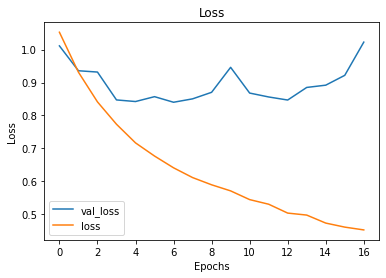

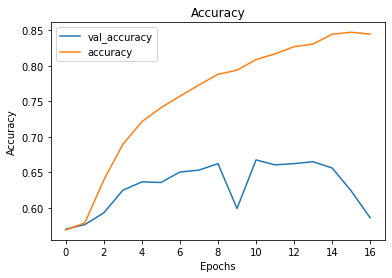

<Figure size 432x288 with 0 Axes>

In [116]:
visualize_training_results(result_6)
plt.savefig(r'final_model.jpg', bbox_inches='tight');

Model 6 seems to have performed the best at 65.44% test accuracy. The difference between training and test accuracy confirms that our model has overfit. Trying different loss fuctions and adding multiple layers does not seem to improve our model. This means that our data is just not enough to train our model effectively and predict better results. 

We will finalize our model with LSTM architecture using L1 regularization parameter and sigmoid as it's activation function.

### Applying the Model

In [117]:
# Pick a random tweet
random_index = random.randint(5000)

sample_tweet = df_clean['tweet_text'].iloc[random_index]
sample_label = df_clean['emotion'].iloc[random_index]

# Use the model to predict a review 
print(sample_tweet) 

# Label final categories
sentiment = ['Neutral','Positive', 'Negative']

# Create the sequences
sample_sequences = tokenizer.texts_to_sequences(sample_tweet)
sample_padded = pad_sequences(sample_sequences, padding='post', maxlen=max_len)           

Prediction = sentiment[np.around(model6.predict(sample_padded), decimals=0).argmax(axis=1)[0]]
print('\n', 'Predicted Class =', Prediction)
print('Actual Class =', sample_label)

Audioboo: The front of the Apple iPad 2 queue {link} #sxsw #sxswsa #apple #ipad2 #Austin #Texas

 Predicted Class = Neutral
Actual Class = Neutral emotion
